## Forex model
These area theh intial model candidates:
1. Exponential smoothing
2. Markov switching
3. ARIMA
4. GBRT(XGBoost implementation)
5. LSTM(if others do not achieve a statisfactory R^2)

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import xgboost
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from datetime import datetime, timedelta

In [2]:
# Import data: the ports are mapped to 5454.

host = "localhost"
port = "5454"
db = "forex"
con = create_engine(f"postgresql://airflow:airflow@{host}:{port}/{db}")

In [3]:
ex_rates = pd.read_sql_query("SELECT * FROM ex_rates", con=con.connect().connection)

/tmp/ipykernel_103003/3048849573.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ex_rates = pd.read_sql_query("SELECT * FROM ex_rates", con=con.connect().connection)


In [4]:
ex_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86223 entries, 0 to 86222
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   currency     86223 non-null  int64         
 1   time_period  86223 non-null  datetime64[ns]
 2   rate         86223 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 MB


In [28]:
# As mentioned in tsa.R, we have to remove BGN(Bulgarian lev), since it is pegged to euro, and it may mess up calculations
currency_codes = pd.read_sql_query("SELECT * FROM dim_currency", con=con.connect().connection)
currency_codes.head()

bgn_code = currency_codes[currency_codes['name'] == "BGN"]\
  ['ex_id'].values[0]

ex_rates = ex_rates[ex_rates['currency'] != bgn_code]

/tmp/ipykernel_103003/1397585027.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  currency_codes = pd.read_sql_query("SELECT * FROM dim_currency", con=con.connect().connection)


In [30]:
def prepare_ts(data):
  return data.set_index('time_period').asfreq('d').bfill()

In [31]:
def train_test_ts(data, tresh_date) -> tuple[pd.DataFrame] | None:
  train = prepare_ts(data[data['time_period'] < tresh_date])

  test = prepare_ts(data[data['time_period'] > tresh_date])

  if test.shape[0] == 0:
    return (None, None)
  
  return (train, test)

## Holt's smoothing

In [6]:
tresh_date = datetime(2024, 11, 1)
mask = ex_rates['time_period'] < tresh_date
df = ex_rates.groupby('currency')

preds = {}

for group, data in df:
  train, test = train_test_ts(data, tresh_date)

  if test is None:
    continue

  holt = Holt(train['rate']).fit()

  pred = holt.predict(start=datetime(2024, 11, 1), end=datetime(2024, 12, 1))
  preds[group] = (pred, test['rate'])

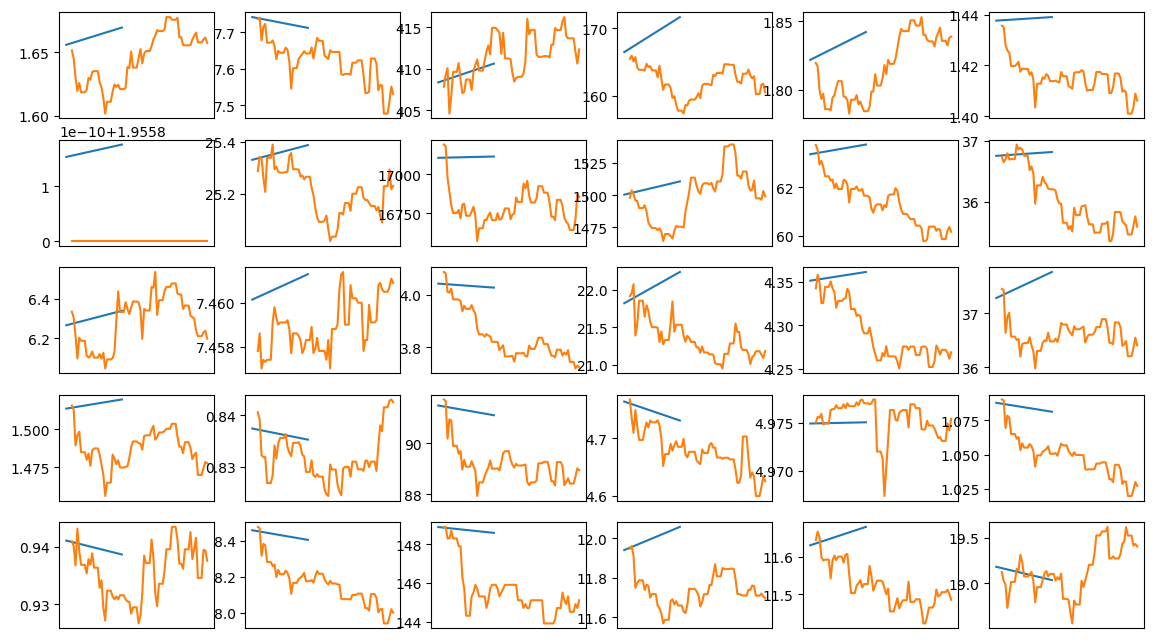

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 8))

for i, key in enumerate(preds):
  pred, target = preds[key]

  axs[i%5][int(i/5)].plot(pred)
  axs[i%5][int(i/5)].plot(target)

  axs[i%5][int(i/5)].tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
  )

#### These forecasts aren't statisfactory for some currencies, I think, that we can do better

## ARIMA models

#### For stationarity: only a small portion of exchange rates are stationary. However after differencing once, we obtain stationary time series (from `tsa.R`). We can apply this knowledge here:

In [10]:
from pmdarima.arima import auto_arima

In [296]:
sample = df.get_group(39).set_index('time_period').asfreq('d').bfill()
model = auto_arima(sample['rate'])

In [18]:
preds = {}

for group, data in df:
  train, test = train_test_ts(data, tresh_date)

  if test is None:
    continue

  model = auto_arima(train["rate"])

  pred = model.predict(test.shape[0])
  preds[group] = (pred, test['rate'])

/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/home/lukas/prog

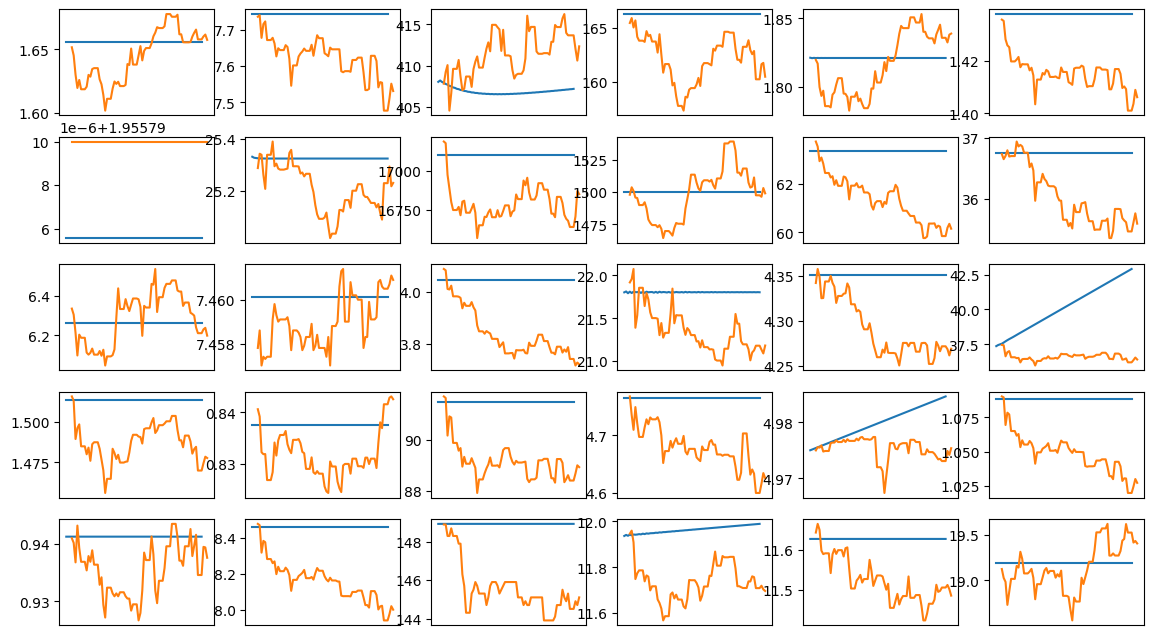

In [20]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 8))

for i, key in enumerate(preds):
  pred, target = preds[key]

  axs[i%5][int(i/5)].plot(pred)
  axs[i%5][int(i/5)].plot(target)

  axs[i%5][int(i/5)].tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
  )

### This model is even worse, than last one. As expected Holt's smoothing is better

> A model, which I would love to try is Markov autoregression, however doesn't seem like, there are any decent implementation in Python, that would allow me to make forecasts using it

#### Since, statistical time-series models are not statisfactory: they either produce inconsistent or useless results in this case. (Markov autoregression is not implemented yet, ARCH may produce better results, but it does seem as if the time-series are variance-stationary)

## XGBoost

#### Now, I will move on to GBRT window-based model

In [98]:
input_lags = 3 
output_lags = 3

for i in range(1, input_lags+1):
  sample[f'rate-{i}'] = sample['rate'].shift(-i)

for j in range(1, output_lags+1):
  sample[f'rate+{j}'] = sample['rate'].shift(j)

sample.dropna()

,currency,rate,rate-1,rate-2,rate-3,rate+3,rate+1,rate+2
time_period,,,,,,,,
2015-01-05,7.0,27.676,27.695,27.783,27.865,27.693,27.676,27.676
2015-01-06,7.0,27.695,27.783,27.865,28.062,27.676,27.676,27.676
2015-01-07,7.0,27.783,27.865,28.062,28.287,27.676,27.695,27.676
2015-01-08,7.0,27.865,28.062,28.287,28.287,27.676,27.783,27.695
2015-01-09,7.0,28.062,28.287,28.287,28.287,27.695,27.865,27.783
...,...,...,...,...,...,...,...,...
2025-01-09,7.0,25.116,25.090,25.230,25.230,25.154,25.150,25.137
2025-01-10,7.0,25.090,25.230,25.230,25.230,25.137,25.116,25.150
2025-01-11,7.0,25.230,25.230,25.230,25.294,25.150,25.090,25.116


In [107]:
# Because, we may experiment with different time windows for input and output, I will write a windowing function

def window_data(data: pd.DataFrame,
                input_lags: int,
                output_lags: int,
                feature_cols : list[str] | None = None) -> tuple[np.ndarray]:

  output = pd.DataFrame()
  feat_cols = []
  output_cols = []

  for i in range(1, input_lags+1):
    output[f'rate-{i}'] = data['rate'].shift(-i)
    feat_cols.append(f'rate-{i}')

  output['rate'] = data['rate']

  for j in range(1, output_lags+1):
    output[f'rate+{j}'] = data['rate'].shift(j)
    output_cols.append(f'rate+{j}')

  if feature_cols is not None:
    for col in feature_cols:
      output[col] = data[col]
      output_cols.append(col)

  output.dropna(inplace=True)

  return output.loc[:, feat_cols].values, output.loc[:, output_cols].values

In [116]:
X, y = window_data(sample, 20, 7)

In [119]:
from sklearn.model_selection import RandomizedSearchCV

In [120]:
params = {
  'max_depth': np.arange(2, 10, step=4),
  'eta': np.logspace(-4, 0),
  'n_estimators': np.arange(3, 15, step=3)
}

In [209]:
def train_trees(df, 
                input_lags, 
                output_lags, 
                model,
                params):

  importances = {}
  models = {}
  scores = {}

  for group, data in df:
  # Use the data of a month, to forecast seven days into the future
    X, y = window_data(prepare_ts(data), input_lags, output_lags)

    rcv = RandomizedSearchCV(
      estimator = model,
      param_distributions= params,
      n_jobs=-1
    )

    rcv.fit(X, y)

    models[group] = rcv.best_estimator_
    scores[group] = rcv.best_score_
    importances[group] = rcv.best_estimator_.feature_importances_

  return importances, models, scores

In [166]:
model = xgboost.XGBRegressor()
importances, models, scores = train_trees(df, 30, 7, model, params)

#### Some scores are abismal, so we need to analyze and improve the model

<Axes: >

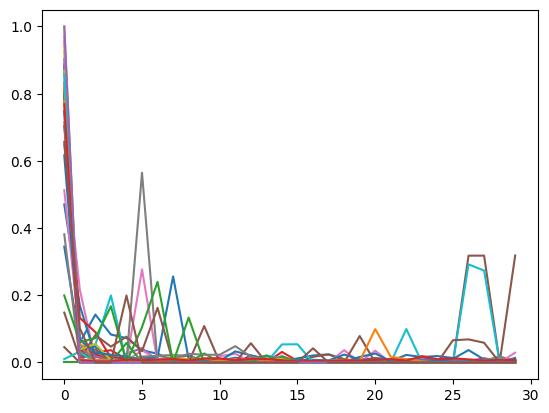

In [142]:
importances = pd.DataFrame(importances)
importances.plot(legend=False)

### It seems like, the most significant feature is the rate-1 (one day difference). However, for some, it is not the case. Maybe those indicate the failed currencies

In [151]:
mask = importances.apply(np.argmax) != 0
np.array(scores)[mask]

array([ 7.15937832e-02,  2.82019513e-01,  5.63990959e-01, -7.01330972e-01,
       -1.02964280e+02])

#### We can see, that it is not the problem, the number of features probably didn't cause such horrible performance

#### Let's take a sample model and look, at what are the tree parameters: maybe the lack of depth or estimators caused this bad performance

<Axes: >

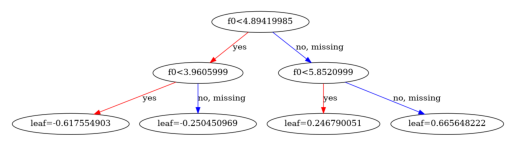

In [168]:
xgboost.plot_tree(models[3])

In [173]:
models[0].max_depth

2

#### The tree is just too shallow, and the number of estimators is really large: I need to use less estimators and deeper trees

In [174]:
params = {
  'n_estimators': np.arange(5, 15, step=5),
  'eta': np.logspace(-5, 0, num=5),
  'max_depth': np.arange(5, 20, step=5)
}

In [175]:
importances, models, scores = train_trees(df, 15, 7, model, params)

In [176]:
scores

{0: -3.9187727789637137,
 1: 0.7333068606693021,
 2: -3532501724719.654,
 3: 0.9247709483556458,
 4: 0.8418599655646533,
 5: 0.6348654035035122,
 6: 0.8184165111196708,
 7: 0.37379288376457437,
 8: 0.662867316935203,
 9: 0.34951589409866457,
 13: 0.4477295851429213,
 18: 0.7465571324613983,
 19: 0.562185189890949,
 20: 0.7373387636403621,
 21: 0.89275706468202,
 22: 0.6287503277184697,
 23: 0.585086114558077,
 24: 0.6215160638968749,
 25: 0.12995888877629386,
 26: 0.3219319747006739,
 27: -0.18903507242690937,
 28: 0.8401209244511263,
 29: 0.15340774643656302,
 30: 0.15872128654371798,
 31: -0.2876408382202118,
 32: 0.27702874762743124,
 33: 0.7397188759675959,
 34: -1.4570544220057464,
 35: 0.7760385195434101,
 36: 0.003233209189653685,
 37: 0.7524574087775646,
 38: 0.6942954343617723,
 39: -2.433938517686552,
 40: 0.6126470820514726,
 41: 0.7491884810772456,
 42: 0.7199326703116958}

### With the improvements of the parameter distribution, we obtain better R^2 metrics. However, we still have a problem with a few currencies.

Score for currency 39: -2.433938517686552


<Axes: >

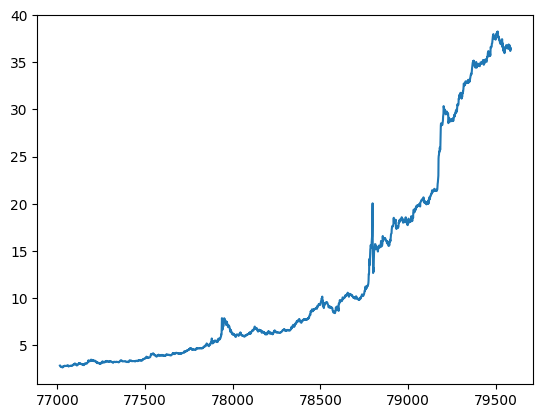

In [183]:
print(f"Score for currency 39: {scores[39]}")
df.get_group(39).rate.plot()

In [301]:
sample = df.get_group(39)
sample['t'] = (sample['time_period'] - sample['time_period'].min()).map(lambda x: x.days)
sample.head()

/tmp/ipykernel_103003/2509189229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['t'] = (sample['time_period'] - sample['time_period'].min()).map(lambda x: x.days)


,currency,time_period,rate,t
77015,39,2015-01-02,2.8332,0
77016,39,2015-01-05,2.7869,3
77017,39,2015-01-06,2.7732,4
77018,39,2015-01-07,2.7547,5
77019,39,2015-01-08,2.7181,6


#### The ones with a significant trend are the ones, that cause trouble, so we need to create a pipeline, that detrends the time-series, before it gets fit into the GBRT

In [232]:
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor

In [302]:
estimators = [('ridge', Ridge())]
final_est = xgboost.XGBRegressor(max_depth=5, n_estimators=10)

model = MultiOutputRegressor(
  StackingRegressor(
    estimators=estimators,
    final_estimator=final_est
  ))

In [303]:
mask = sample['time_period'] < datetime(2024, 10, 1)

X_train, y_train = window_data(prepare_ts(sample[mask]), 10, 7, ['t'])
X_test, y_test = window_data(prepare_ts(sample[~mask]), 10, 7, ['t'])

In [304]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Ridge())],
                                                 final_estimator=XGBRegressor(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric=None,
                                                                              feature_types=None,
                                                                              gamma=None,
                                                                              grow_policy=None,
                                                                              importance_type=None,
                                                                              interaction_constraints=None,
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=5,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=10,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...)))

In [305]:
model.score(X_test, y_test)

-66.02707276912868

### Stacking regression does not solve the problem

In [306]:
from statsmodels.nonparametric.smoothers_lowess import lowess

### So the final regression strategy: LOWESS(locally-linear regression) for determining the deterministic part with XGBoost(gradient-boosted tree).

In [321]:
def score_rate_model(df):
  output = {
    'score': [],
    "currency": [],
    "xgb_model": []
  }

  for group, data in df:
    output['currency'].append(group)

    data['t'] = (data['time_period'] - data['time_period'].min())\
      .map(lambda x: x.days)
    
    trend_y = lowess(data['t'], data['rate'], return_sorted=False)
    
    data['trend'] = trend_y
    data['rate'] = data['rate'] - data['trend']

    model = xgboost.XGBRegressor()

    X, y = window_data(prepare_ts(data), 10, 7)

    rcv = RandomizedSearchCV(
      model,
      param_distributions=params
    )
    rcv.fit(X, y)

    output['score'].append(rcv.best_score_)
    output['xgb_model'].append(rcv.best_estimator_)

  return output

In [322]:
res = score_rate_model(df)
res['score']

/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


[-3.2217240809911885,
 -0.5219047494418263,
 -3.0804723562632505e+24,
 0.8322002630601801,
 0.36113348966335057,
 0.6762975493127802,
 0.7785764139166121,
 0.5669001229545338,
 0.4429083177680642,
 -16.455029190132,
 0.5485786423706249,
 0.6831205112964677,
 -1.3516595500902084,
 0.7503059241598533,
 0.8474881655088474,
 0.7162015378862269,
 -4.847678273562486,
 0.525201948228751,
 0.06883902767658094,
 0.4509652792014102,
 0.3195253902176483,
 0.7004326020822107,
 0.6952392161931205,
 0.43777807755117826,
 0.8010647699939369,
 0.18951827399726334,
 0.8069383256621585,
 -0.8025720002920387,
 0.7482432514259024,
 0.09903028083723804,
 0.5561029275632822,
 0.810066290902238,
 -2.4115103846304944,
 0.6463451617632618,
 0.6844244945884004,
 0.7088488084047123]

### Even after detrending with a locally linear regression model, we do not obtain a great model, that works for all currencies, but a lot of currencies are very well forecasted using just XGBoost. Thus it will be the model, that I will use for forecasts